# Assignment 1 - Yelp data

First, import relevent libraries. Add useful functions from the "useful gems" lab.I have also included a helper function to tell me that my browser is not crashing.

In [2]:
import tensorflow as tf
import sys
import sklearn as sk
import pandas as pd
import json
import csv
import time, sys
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from scipy.stats import zscore
import sklearn.feature_extraction.text as sk_text
from sklearn.neighbors import KNeighborsRegressor
from collections.abc import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn import metrics
import winsound



# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
#Show progress bar in loop
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

#Let me know when you're done!
def beep():
    duration = 500  # milliseconds
    freq = 1040  # Hz
    winsound.Beep(freq, duration)

loadFresh=0

First determine businesses have enough reviews to be relevent for training


In [2]:
if(loadFresh):
    #Convert raw business data into tsv
    outfile = open("businesses.tsv", 'w')
    sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
    sfile.writerow(['business_id','stars', 'review_count'])
    with open('yelp_dataset/business.json', encoding="utf-8") as f:
     i=0
     for line in f:
        row = json.loads(line)
        if(row['review_count']>=20):
            sfile.writerow([row['business_id'], row['stars'], (row['review_count'])])
        i=i+1
        update_progress(i / 192610)

    update_progress(1);
    outfile.close()

Progress: [####################] 99.9%


In [3]:
#load business table
business_df= pd.read_csv('businesses.tsv', delimiter ="\t", encoding="utf-8")
business_df=business_df.sort_values('business_id');
business_df

,business_id,stars,review_count
45042,--1UhMGODdWsrMastO9DZw,4.0,24
11344,--6MefnULPED_I942VcFNA,3.0,44
29166,--7zmmkVg-IMGaXbuVd0SQ,4.0,58
49157,--9e1ONYQuAa-CB_Rrw7Tw,4.0,1613
37751,--DaPTJW3-tB1vP-PfdTEg,3.5,49
...,...,...,...
44660,zzsOLFhgUw8gnjLTVVItFA,4.5,105
13453,zzwaS0xn1MVEPEf0hNLjew,3.5,68
356,zzwhN7x37nyjP0ZM8oiHmw,4.0,54
46061,zzwicjPC9g246MK2M1ZFBA,3.0,70


Found 57644 with enough reviews to be useful. All stored in business_df, ordered by business ID

## Review data
Open the review data and convert into a TSV with only the relevent information. Runs a progress bar while loading. To save space, only writes to file if the business has 20 reviews or more.

In [ ]:
if(loadFresh):
    #Convert raw review data into TSV
    outfile = open("review_stars.tsv", 'w')
    sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
    sfile.writerow(['business_id','stars', 'text'])
    with open('yelp_dataset/review.json', encoding="utf-8") as f:
     i=0
     for line in f:
        row = json.loads(line)
        # Check if businessID if present in business table
        if(row['business_id'] in business_df['business_id'].tolist()):
            # some special char must be encoded in 'utf-8'
            sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])
        update_progress(i / 2000000)
        i=i+1

    update_progress(1);
    outfile.close()

Progress: [###########---------] 55.1%


In [4]:
#load review data
df= pd.read_csv('review_stars-small.tsv', delimiter ="\t", encoding="utf-8")
df

,business_id,stars,text
0,ujmEBvifdJM6h6RLv4wQIg,1.0,b'Total bill for this horrible service? Over $...
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,"b""I *adore* Travis at the Hard Rock's new Kell..."
2,WTqjgwHlXbSFevF32_DJVw,5.0,"b""I have to say that this office really has it..."
3,b1b1eb3uo-w561D0ZfCEiQ,1.0,b'Today was my second out of three sessions I ...
4,eU_713ec6fTGNO4BegRaww,4.0,b'I\'ll be the first to admit that I was not e...
...,...,...,...
42205,nrahyQyopCtajDqUtVVVfA,2.0,b'My husband and I thought we would give The S...
42206,RJdSwvgAd2TRdQw4iOsrag,4.0,"b""Petit caf\xc3\xa9 sympa, peu de place assise..."
42207,coGEHGuUtnABP7KHgGlmRg,5.0,b'Absolutely delicious! The food was full of a...
42208,cMAv53bpH7b32IYgQwCXLA,2.0,b'i would understand a 2 hour wait for food if...


## Language preprocessing
First, aggregates all reviews under their business ID. Then we can run TFIDF on the sum of all the reviews in preparation to do language analysis.

In [5]:
#groups reviews by businessID
df_review_group=df.groupby('business_id')['text'].sum()
df_reviews = pd.DataFrame({'business_id':df_review_group.index, 'all_reviews':df_review_group.values})
df_reviews

#language preprocessing
vectorizer = sk_text.TfidfVectorizer(stop_words='english',
                             min_df=2, 
                             max_df=500)

#df_reviews['all_reviews'] = vectorizer.fit_transform(df_reviews['all_reviews'])
vector_reviews=vectorizer.fit_transform(df_reviews["all_reviews"])

#split off business ID
col_id=df_reviews['business_id']
#create dataframe from vectored reviews
df_vector_reviews=pd.DataFrame(vector_reviews.todense())
#concat to single dataframe
df_tfidf_reviews=pd.concat([col_id,df_vector_reviews],axis=1)

display(df_tfidf_reviews)

,business_id,0,1,2,3,4,5,6,7,8,...,27037,27038,27039,27040,27041,27042,27043,27044,27045,27046
0,--I7YYLada0tSLkORTHb5Q,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-092wE7j5HZOogMLAh40zA,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1VaIJza42Hjev6ukacCNg,0.094521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1xuC540Nycht_iWFeJ-dw,0.022954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-49WY_TEa9ZEcRk_GnuLog,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,zyPGYeXF4XKCqNN1pjFWhg,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5134,zyr5pzOs3SJIX3K-nvC2zg,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5135,zz3CqZhNx2rQ_Yp6zHze-A,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5136,zzOo9n22fBbKAhbSpMzggA,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#join total reviews with aggregated review data
df_join=pd.concat([df, df_tfidf_reviews], axis=1, join='inner')
#drop unnecesary info
df_sklearn_ready=df_join.drop(columns=['business_id', 'text'])
df_sklearn_ready

,stars,0,1,2,3,4,5,6,7,8,...,27037,27038,27039,27040,27041,27042,27043,27044,27045,27046
0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.094521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.022954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,3.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5134,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5135,5.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5136,5.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Y is our list of reviews and X is your table of language data.

In [7]:
#get arrays for training
y=df_sklearn_ready["stars"].values
x=df_sklearn_ready.drop(["stars"], axis=1).values
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)


In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3596, 27047)
(3596,)
(1542, 27047)
(1542,)


Now the data is clean and it's time to feed it to the AI

# Machine learning
## TensorFlow Regression
Since the idea is to make a bunch of models to test, to start here are some functions to repeatedly create and test models

In [ ]:
#function to make model
def make_model(x,y,firstLayer=25,secondLayer=10,epochs=50, optimizer='adam', activation='relu',
               stopEarly=1, monitor='loss', min_delta=0.001, patience=2, verbose=2):
    model = Sequential()

    #Set up layers
    model.add(Dense(25, input_dim=x.shape[1], activation=activation)) # Hidden 1 
    model.add(Dense(10, activation)) # Hidden 2
    model.add(Dense(1)) # Output

    model.compile(loss='mean_squared_error', optimizer=optimizer)

    model.fit(x, y, verbose=verbose, epochs=epochs)
        
    return model

## Testing with RSME Score

In [ ]:
#function to test a bunch of models and return the best one
def test_models(models, x, y):
    #used to return best model, but used too much memory
    best_i=-1
    i=0
    best_rmse=5;
    for model in models:
        pred=model.predict(x)
        #compare actual to predicted
        score = np.sqrt(metrics.mean_squared_error(pred,y))
        print(score)
        if(score<best_rmse):
            best_i=i
            best_rmse=score
        i=i+1
    return models[best_i]

Create models with different control variables, several times

## Experimentation
Now we will creatie many models with different starting points, attributes, and algorithms.

First we will test adam vs. sgd

Train on 3596 samples, validate on 1542 samples
Epoch 1/1000
3596/3596 - 2s - loss: 6.9607 - val_loss: 2.3382
Epoch 2/1000
3596/3596 - 1s - loss: 2.1023 - val_loss: 2.1611
Epoch 3/1000
3596/3596 - 1s - loss: 2.0698 - val_loss: 2.1656
Epoch 4/1000
3596/3596 - 1s - loss: 2.0670 - val_loss: 2.1641
Epoch 5/1000
3596/3596 - 1s - loss: 2.0652 - val_loss: 2.1697
Epoch 6/1000
3596/3596 - 1s - loss: 2.0634 - val_loss: 2.1696
Epoch 7/1000
3596/3596 - 1s - loss: 2.0620 - val_loss: 2.1608
Epoch 00007: early stopping
Score (RMSE): 1.4699768188207512


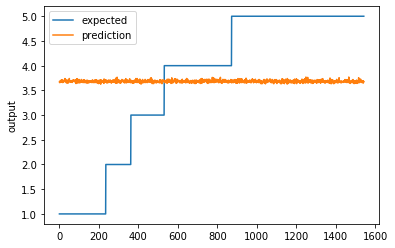

In [21]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer], verbose=2,epochs=1000)
model.load_weights('best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)

## Save the best one

In [ ]:
import os
# save entire network to HDF5
best_model.save("network.hdf5")

In [ ]:
from tensorflow.keras.models import load_model

model2 = load_model("network.hdf5")
pred = model2.predict(x_test)
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("After load score (RMSE): {}".format(score))

In [ ]:
beep()